In [3]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics
%load_ext autoreload
%autoreload 2

def printmd(string):
    display(Markdown(string))    
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
%matplotlib inline
from shap_utils import *
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  
from Shapley import ShapNN
from DShap_run import DShap
from shap_utils import *
import shap_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 
                'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                'income']

train = pd.read_csv('./data/uci/data.train', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('./data/uci/data.test', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')

adult = pd.concat([test,train])

adult.reset_index(inplace = True, drop = True)
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')

In [5]:
# removing ? and Nan
print(adult.shape)
adult = adult.dropna(how='any')
# print(adult.iloc[4,1])
print(adult.shape)
adult = adult[(adult.astype(str) != '?').all(axis=1)]
print(adult.shape)

(48843, 15)
(48842, 15)
(45222, 15)


In [6]:
# Data Prep
adult_data = adult.drop(columns = ['income'])
adult_label = adult.income

le = preprocessing.LabelEncoder()
le.fit(adult_label)
adult_label = le.transform(adult_label)

adult_cat_1hot = pd.get_dummies(adult_data.select_dtypes('category'))
adult_non_cat = adult_data.select_dtypes(exclude = 'category')
adult_data_1hot = pd.concat([adult_non_cat, adult_cat_1hot], axis=1, join='inner')

# print(adult_data_1hot)
# ind = np.random.permutation(len(adult_data_1hot))
# adult_data_1hot, adult_label = adult_data_1hot[ind], adult_label[ind]


idx0 = np.where(adult_label == 0)[0]
idx1 = np.where(adult_label == 1)[0]
print(len(idx0),len(idx1))
# print(idx0[:10])

adult_data_1hot = adult_data_1hot.to_numpy()
adult_label = adult_label
# print(adult_data_1hot[0])
train_size = 500
test_size = 250
heldout_size = 500

# print(adult_data_1hot(idx0[:train_size]))
train_data = np.concatenate((adult_data_1hot[idx0[:train_size]], adult_data_1hot[idx1[:train_size]]), 0)
train_label = np.concatenate((adult_label[idx0[:train_size]], adult_label[idx1[:train_size]]), axis=0)
test_data = np.concatenate((adult_data_1hot[idx0[train_size:train_size+test_size]], adult_data_1hot[idx1[train_size:train_size+test_size]]),0)
test_label = np.concatenate((adult_label[idx0[train_size:train_size+test_size]], adult_label[idx1[train_size:train_size+test_size]]), 0)
heldout_data = np.concatenate((adult_data_1hot[idx0[train_size+test_size:train_size+test_size+heldout_size]], adult_data_1hot[idx1[train_size+test_size:train_size+test_size+heldout_size]]), 0)
heldout_label = np.concatenate((adult_label[idx0[train_size+test_size:train_size+test_size+heldout_size]], adult_label[idx1[train_size+test_size:train_size+test_size+heldout_size]]), 0)

print(train_data.shape, heldout_data.shape, test_data.shape)
# print(heldout_label[-10:])
# idx0 = np.where(train_label == 0)[0]
# idx1 = np.where(train_label == 1)[0]
# print(len(idx0),len(idx1))

# Normalization
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(train_data)  
train_data = scaler.transform(train_data)  

# Applying same transformation to test data
test_data = scaler.transform(test_data)
heldout_data = scaler.transform(heldout_data)

34014 11208
(1000, 254) (1000, 254) (500, 254)


In [7]:
print(train_data.shape, train_label.shape)
print(heldout_data.shape, heldout_label.shape)

# printmd('## 1.4. Missing values')
# for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
#     if j > 0:
#         printmd(str(i) + ': ' + str(j) + ' records')

(1000, 254) (1000,)
(1000, 254) (1000,)


In [8]:
# print(train_label[:5])
model = "uci"
clf = return_model(model)
# xx = 1000
clf.fit(train_data, train_label)
# pre_t = clf.predict(test_data)
directory = './temp_ds_uci'

test_acc = clf.score(heldout_data, heldout_label)
print(test_acc)
num_test = test_data.shape[0]
print(num_test)

# dshap = DShap(train_data, train_label, test_data, test_label, num_test, sources=None, model_family=model, metric='accuracy',
#               directory=directory, seed=0)
# print(dshap.X.shape, dshap.y.shape, dshap.X_test.shape, dshap.y_test.shape)
# dshap.run(100, 0.5)

0.734
500


In [9]:
from models.uci import *
from utils import *
#data preparation
batch_size = 1024
epochs = 400

x_train = torch.from_numpy(train_data).contiguous().view(-1, 254)
y_train = torch.from_numpy(train_label).view(-1,).long()
print("train_size:", x_train.shape)
x_test = torch.from_numpy(test_data).contiguous().view(-1, 254)
y_test = torch.from_numpy(test_label).view(-1,).long()
print("test_size:", x_test.shape)
x_heldout = torch.from_numpy(heldout_data).contiguous().view(-1, 254)
y_heldout = torch.from_numpy(heldout_label).view(-1,).long()
print("heldout_size:", x_heldout.shape)

device = torch.device('cuda')
uci = UCI().to(device)
optimizer = optim.Adam(uci.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(uci, device, x_train, y_train, batch_size, optimizer, criterion, epochs)
accuracy, avg_loss = evaluate(uci, device, x_train, y_train, batch_size, criterion)
print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
accuracy, avg_loss = evaluate(uci, device, x_heldout, y_heldout, batch_size, criterion)
print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

train_size: torch.Size([1000, 254])
test_size: torch.Size([500, 254])
heldout_size: torch.Size([1000, 254])



[Train] Accuracy: 91.50%, loss:  0.0002
[Test] Accuracy: 75.90%, loss:  0.0006


In [12]:
deep_f_train = []
deep_f_test = []
targets = []
for X, y in batch(x_train, y_train, batch_size):
    X = X.to(device).float()
    fc3, y_pre = uci(X)
    deep_f_train.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

for X, y in batch(x_test, y_test, batch_size):
    X = X.to(device).float()
    fc3, y_pre = uci(X)
    deep_f_test.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

deep_f_train = np.concatenate(deep_f_train) # deep features are not normalized
deep_f_test = np.concatenate(deep_f_test) # deep features are not normalized
print(deep_f_train.shape, deep_f_test.shape)

(1000, 100) (500, 100)


In [13]:
# import pickle
# store_data = './exp_data/DS_uci/'
# f = open(store_data+'data.pkl', 'wb')
# data_write = {'x_train': x_train, 'y_train': y_train, 'x_test':x_test, 'y_test': y_test, 
#               'x_heldout': x_heldout, 'y_heldout': y_heldout}
# pickle.dump(data_write, f)
# f.close() 
# f = open(store_data+'values.pkl', 'wb')
# data_write = {"knn_values:": fc1_knn_values}
# pickle.dump(data_write, f)
# f.close()

In [14]:
import math
kmin = 5
kmax = 6
kinterval = 5
fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features
loo_fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features

# t = 10000
for i, k in enumerate(range(kmin, kmax, kinterval)):
    print("neighbour number:", k)
#     fc1_knn_values[i],*_ = old_knn_shapley(k, deep_f[:train_data.shape[0]], deep_f[train_data.shape[0]:], 
#                                   y_deep[:train_data.shape[0]], y_deep[train_data.shape[0]:])
#     loo_fc1_knn_values[i],*_ = loo_knn_shapley(k, deep_f[:train_data.shape[0]], deep_f[train_data.shape[0]:], 
#                                   y_deep[:train_data.shape[0]], y_deep[train_data.shape[0]:])
    loo_fc1_knn_values[i],*_ = loo_knn_shapley(k, deep_f_train, deep_f_test, y_train, y_test)
    fc1_knn_values[i],*_ = old_knn_shapley(k, deep_f_train, deep_f_test, y_train, y_test)

neighbour number: 5


In [20]:
import pickle
tmc_path = './temp_ds_uci/'
with open(tmc_path+'mem_tmc_0000.pkl', 'rb') as f:
    tmc = pickle.load(f)
    print(tmc)
    tmc_values = np.mean(tmc["mem_tmc"], axis=0)
with open(tmc_path+'mem_g_0000.pkl', 'rb') as f:
    g = pickle.load(f)
    g_values = np.mean(g["mem_g"], axis=0)
tmc_path = './temp_ds_uci_loo/'

with open(tmc_path+'loo.pkl', 'rb') as f:
    loo = pickle.load(f)
    loo_values = loo['loo']
# print(len(g_values), len(tmc_values))
print(len(loo_values))

{'mem_tmc': array([[ 0.012, -0.018, -0.014, ..., -0.006,  0.028,  0.002],
       [ 0.01 , -0.04 ,  0.006, ...,  0.004,  0.018,  0.002],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.006,  0.036, -0.004, ...,  0.04 ,  0.008,  0.05 ],
       [ 0.018, -0.028, -0.014, ..., -0.026, -0.01 , -0.014],
       [-0.014, -0.01 ,  0.03 , ...,  0.022, -0.006, -0.032]]), 'idxs_tmc': array([[562,  58, 451, ...,  33,  25, 526],
       [784, 245,   1, ..., 637, 906, 405],
       [794, 121, 113, ..., 528, 226, 265],
       ...,
       [810,  17, 696, ..., 597, 932, 866],
       [168, 841, 139, ..., 876, 424,  79],
       [307,  28, 902, ..., 338, 336, 622]]), 'err_tmc': 1104001.32045636}
1000


In [28]:
import math, random
# print(avg_knn_values)
seed = 666
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True

# remove new data to the train set and draw the picture
def plot_summarization(loo_pre_idx, tmc_pre_idx, g_values, knn_values, loo_knn_values, kmin, kmax, kinterval, x_train, y_train, 
                     x_test, y_test, HtoL=False):
    sns.set()
    plt.figure()    
    # set the model deterministic
    seed = 0
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    plt.xlabel('Fraction of train data removed (%)')
    plt.ylabel('Prediction accuracy (%)')
    
    tmc_accs = []
    knn_accs = [[] for _ in range(len(knn_values))]   
    loo_knn_accs = [[] for _ in range(len(knn_values))]   
    marks = ['o-', '*-', 's-', 'v-', '^-', '.-', '1-', '2-']
    colors = ['b', 'g', 'r', 'y', 'c', 'm', 'olive', 'pink']
    labels = [i for i in range(kmin, kmax, kinterval)]
    model = 'uci'
#     model = 'logistic'
    count = int(len(x_train)/2)
    interval = int(count*0.02)
    x = np.arange(0, count, interval)/len(x_train)
    

    if(HtoL == True):
        print("removing data from Highest to Lowest!")
        knn_pre_idx = np.flip(knn_pre_idx, 1)
        tmc_pre_idx = np.flip(tmc_pre_idx, 0)
        loo_pre_idx = np.flip(loo_pre_idx, 0)        
    else:
        print("removing data from Lowest to Highest!")

        
#  G Shapley
    print("G")
    g_accs = []
    idxs = np.argsort(g_values)
    keep_idxs = idxs.tolist()
    for j in range(0, count, interval):
        if len(keep_idxs) == len(x_train):
            x_train_keep, y_train_keep = x_train, y_train
        else:
            x_train_keep, y_train_keep = x_train[keep_idxs], y_train[keep_idxs]     
        clf_g = return_model(model)
        clf_g.fit(x_train_keep, y_train_keep)
        acc = clf_g.score(x_test, y_test)
        print(len(keep_idxs), acc)
        g_accs.append(acc)
        keep_idxs = keep_idxs[interval:]
    print("G:", g_accs)
    plt.plot(x, g_accs, '-', label='G Shapley', color='olive')
             
             
    # TMC Shapley
    print("TMC")
    tmc_accs = []
    idxs = np.argsort(tmc_pre_idx)
    keep_idxs = idxs.tolist()
    for j in range(0, count, interval):
        if len(keep_idxs) == len(x_train):
            x_train_keep, y_train_keep = x_train, y_train
        else:
            x_train_keep, y_train_keep = x_train[keep_idxs], y_train[keep_idxs]     
        clf_tmc = return_model(model)
        clf_tmc.fit(x_train_keep, y_train_keep)
        acc = clf_tmc.score(x_test, y_test)
        print(len(keep_idxs), acc)
        tmc_accs.append(acc)
        keep_idxs = keep_idxs[interval:]
    print("TMC:", tmc_accs)
    plt.plot(x, tmc_accs, '-', label='TMC Shapley', color='olive')

#     # Loo Shapley
    print("Loo")
    loo_accs = []
    idxs = np.argsort(loo_pre_idx)
    keep_idxs = idxs.tolist()
    for j in range(0, count, interval):
        if len(keep_idxs) == len(x_train):
            x_train_keep, y_train_keep = x_train, y_train
        else:
            x_train_keep, y_train_keep = x_train[keep_idxs], y_train[keep_idxs]         
        clf_loo = return_model(model)
        clf_loo.fit(x_train_keep, y_train_keep)
        acc = clf_loo.score(x_test, y_test)
        print(len(keep_idxs), acc)
        loo_accs.append(acc)
        keep_idxs = keep_idxs[interval:]
    print("LOO: ", loo_accs)
    plt.plot(x, loo_accs, '^-', label='LOO', color='pink')

    # Knn Shapley  
    print("KNN")
    for i in range(len(knn_values)):
        idxs = np.argsort(knn_values[i])
        keep_idxs = idxs.tolist()
        x = np.arange(0, count, interval)/len(x_train)
        
        for j in tqdm_notebook(range(0, count, interval), total=int(count/interval), leave=False):
            if len(keep_idxs) == len(x_train):
                x_train_keep, y_train_keep = x_train, y_train
            else:
                x_train_keep, y_train_keep = x_train[keep_idxs], y_train[keep_idxs] 
#                 ind = np.random.permutation(len(x_train_keep))
#                 x_train_keep, y_train_keep = x_train_keep[ind], y_train_keep[ind]
            clf_knn = return_model(model)
            clf_knn.fit(x_train_keep, y_train_keep)
            acc = clf_knn.score(x_test, y_test)
            acc_t = clf_knn.score(x_train_keep, y_train_keep)
#             print(len(x_train_keep), acc)
            knn_accs[i].append(acc)
            keep_idxs = keep_idxs[interval:]
            clf_knn = 0
    for i in range(0, len(knn_values)):
        print(x, knn_accs[i])
        plt.plot(x, knn_accs[i], '-', label="Knn Shapley, K="+str(labels[i]), color=colors[i])
        
#     LOO Knn Shapley
    print("LOO KNN")
    for i in range(len(loo_knn_values)):
        idxs = np.argsort(loo_knn_values[i])
        keep_idxs = idxs.tolist()
        x = np.arange(0, count, interval)/len(x_train)
        
        for j in tqdm_notebook(range(0, count, interval), total=int(count/interval), leave=False):
            if len(keep_idxs) == len(x_train):
                x_train_keep, y_train_keep = x_train, y_train
            else:
                x_train_keep, y_train_keep = x_train[keep_idxs], y_train[keep_idxs]  
#                 ind = np.random.permutation(len(x_train_keep))
#                 x_train_keep, y_train_keep = x_train_keep[ind], y_train_keep[ind]
            clf_knn = return_model(model)
            clf_knn.fit(x_train_keep, y_train_keep)
            acc = clf_knn.score(x_test, y_test)
#             print(len(keep_idxs), acc)
            loo_knn_accs[i].append(acc)
            keep_idxs = keep_idxs[interval:]

    for i in range(0, len(knn_values)):
        print(x, loo_knn_accs[i])
        plt.plot(x, loo_knn_accs[i], '-', label="LOO Knn Shapley, K="+str(labels[i]), color=colors[i+2])    
    
    # random solution
    times = 5
    all_rand_accs = []
    print("random")
    for time in range(times):
        print(time)
        random_accs = []
        keep_idxs = np.arange(0, len(x_train))
        random.shuffle(keep_idxs)
        for j in range(0, count, interval):
            if len(keep_idxs) == len(x_train):
                x_train_keep, y_train_keep = x_train, y_train
            else:
                x_train_keep, y_train_keep = x_train[keep_idxs], y_train[keep_idxs]  
#         print(x_train_keep.shape, y_train_keep.shape)
            clf_random = return_model(model)
            clf_random.fit(x_train_keep, y_train_keep)
            acc = clf_random.score(x_test, y_test)
            random_accs.append(acc)
            keep_idxs = keep_idxs[interval:]
#             print(len(x_train_keep), acc)
        all_rand_accs.append(random_accs)
    all_rand_accs = np.mean(all_rand_accs, 0)
    print("random:", all_rand_accs.tolist())
    plt.plot(x, all_rand_accs, '-', label='random', color='red')   
    
    
    plt.legend()
    plt.tight_layout()
    if(HtoL == True):
        plt.savefig('knnH-L.png')
    else:
        plt.savefig('knnL-H.png')

In [29]:
print(len(fc1_knn_values[0]), len(loo_fc1_knn_values[0]))
print(x_train.shape, x_heldout.shape)
# print(fc1_knn_values[0][600:])

# print(tmc_values)

1000 1000
torch.Size([1000, 254]) torch.Size([1000, 254])


removing data from Lowest to Highest!
G
1000 0.734
990 0.712
980 0.733
970 0.735
960 0.748
950 0.743
940 0.739
930 0.77
920 0.75
910 0.742
900 0.768
890 0.785
880 0.77
870 0.751
860 0.772
850 0.769
840 0.79
830 0.776
820 0.788
810 0.784
800 0.789
790 0.786
780 0.784
770 0.789
760 0.796
750 0.783
740 0.786
730 0.792
720 0.788
710 0.782
700 0.791
690 0.79
680 0.796
670 0.795
660 0.794
650 0.785
640 0.783
630 0.788
620 0.787
610 0.782
600 0.782
590 0.782
580 0.779
570 0.781
560 0.773
550 0.777
540 0.775
530 0.778
520 0.777
510 0.783
G: [0.734, 0.712, 0.733, 0.735, 0.748, 0.743, 0.739, 0.77, 0.75, 0.742, 0.768, 0.785, 0.77, 0.751, 0.772, 0.769, 0.79, 0.776, 0.788, 0.784, 0.789, 0.786, 0.784, 0.789, 0.796, 0.783, 0.786, 0.792, 0.788, 0.782, 0.791, 0.79, 0.796, 0.795, 0.794, 0.785, 0.783, 0.788, 0.787, 0.782, 0.782, 0.782, 0.779, 0.781, 0.773, 0.777, 0.775, 0.778, 0.777, 0.783]
TMC
1000 0.734
990 0.709
980 0.736
970 0.747
960 0.747
950 0.766
940 0.748
930 0.763
920 0.739
910 0.758
900 0.752


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49] [0.734, 0.715, 0.731, 0.747, 0.724, 0.724, 0.738, 0.751, 0.736, 0.739, 0.753, 0.765, 0.766, 0.755, 0.745, 0.757, 0.754, 0.751, 0.759, 0.756, 0.764, 0.76, 0.76, 0.753, 0.771, 0.765, 0.768, 0.775, 0.784, 0.768, 0.766, 0.763, 0.773, 0.755, 0.748, 0.758, 0.745, 0.756, 0.766, 0.761, 0.759, 0.756, 0.762, 0.759, 0.761, 0.765, 0.751, 0.753, 0.747, 0.75]
LOO KNN


KeyboardInterrupt: 

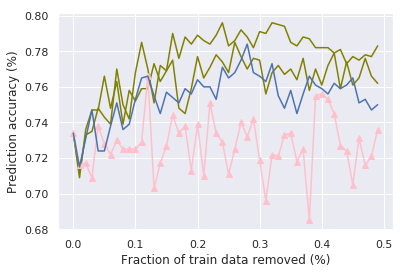

In [30]:
%matplotlib inline
# print(fc1_knn_values[0].shape)
# tt = return_model("uci")
# print(tt)
plot_summarization(loo_values, tmc_values, g_values, fc1_knn_values, loo_fc1_knn_values, kmin, kmax, kinterval, 
          x_train, y_train, x_heldout, y_heldout, False)

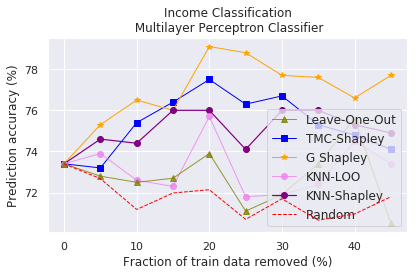

In [21]:
sns.set()

plt.figure()  
plt.xlabel('Fraction of train data removed (%)')
plt.ylabel('Prediction accuracy (%)')
count = int(len(x_train)/2)
# print(count)
interval = int(count*0.02)
x = (np.arange(0, count, interval)/len(x_train)) * 100.0
rand = [0.734, 0.7148, 0.7121999999999999, 0.7106, 0.714, 0.7268, 0.7252000000000001, 0.7114, 0.7156, 0.723, 0.7118, 0.7139999999999999, 0.7238, 0.7264, 0.7256, 0.7198, 0.7196, 0.7196, 0.7283999999999999, 0.714, 0.7214, 0.733, 0.719, 0.72, 0.7096, 0.7069999999999999, 0.7098, 0.7136, 0.7142000000000001, 0.7098, 0.717, 0.718, 0.715, 0.7162, 0.7081999999999999, 0.7066000000000001, 0.7163999999999999, 0.7148, 0.7055999999999999, 0.7158, 0.7096, 0.7036, 0.7074, 0.7167999999999999, 0.7214, 0.718, 0.7048, 0.7065999999999999, 0.7148, 0.7074]

tmc_plot  = [0.734, 0.727, 0.753, 0.732, 0.741, 0.732, 0.734, 0.726, 0.736, 0.77, 0.754, 0.771, 0.733, 0.746, 0.752, 0.764, 0.764, 0.745, 0.762, 0.758, 0.775, 0.765, 0.756, 0.755, 0.744, 0.763, 0.766, 0.749, 0.759, 0.755, 0.767, 0.766, 0.751, 0.757, 0.76, 0.753, 0.756, 0.745, 0.744, 0.747, 0.748, 0.745, 0.745, 0.744, 0.744, 0.741, 0.743, 0.748, 0.76, 0.762]

knn_accs = [0.734, 0.705, 0.715, 0.745, 0.719, 0.746, 0.738, 0.731, 0.742, 0.758, 0.744, 0.756, 0.748, 0.762, 0.751, 0.76, 0.746, 0.746, 0.748, 0.752, 0.76, 0.765, 0.75, 0.765, 0.748, 0.741, 0.757, 0.749, 0.751, 0.744, 0.76, 0.758, 0.748, 0.76, 0.753, 0.76, 0.752, 0.762, 0.748, 0.755, 0.753, 0.763, 0.748, 0.753, 0.758, 0.749, 0.755, 0.779, 0.749, 0.743]

g_plot = [0.734, 0.729, 0.737, 0.747, 0.759, 0.753, 0.754, 0.76, 0.778, 0.759, 0.765, 0.758, 0.771, 0.765, 0.762, 0.76, 0.781, 0.773, 0.782, 0.785, 0.791, 0.781, 0.796, 0.787, 0.786, 0.788, 0.783, 0.783, 0.782, 0.782, 0.777, 0.794, 0.793, 0.776, 0.773, 0.776, 0.777, 0.768, 0.764, 0.771, 0.766, 0.764, 0.771, 0.775, 0.776, 0.777, 0.771, 0.768, 0.773, 0.772]

loo_knn_accs = [0.734, 0.717, 0.758, 0.72, 0.715, 0.739, 0.705, 0.747, 0.729, 0.712, 0.726, 0.736, 0.715, 0.739, 0.73, 0.723, 0.748, 0.736, 0.753, 0.728, 0.757, 0.737, 0.748, 0.747, 0.745, 0.718, 0.733, 0.737, 0.732, 0.75, 0.719, 0.731, 0.763, 0.719, 0.722, 0.724, 0.718, 0.733, 0.738, 0.74, 0.745, 0.739, 0.741, 0.738, 0.729, 0.734, 0.731, 0.727, 0.725, 0.712]

loo_plot = [0.734, 0.716, 0.717, 0.709, 0.738, 0.728, 0.722, 0.73, 0.725, 0.725, 0.725, 0.729, 0.766, 0.703, 0.717, 0.727, 0.744, 0.734, 0.738, 0.713, 0.739, 0.71, 0.751, 0.734, 0.729, 0.711, 0.725, 0.74, 0.732, 0.742, 0.719, 0.696, 0.722, 0.721, 0.733, 0.734, 0.718, 0.725, 0.685, 0.755, 0.756, 0.753, 0.745, 0.727, 0.724, 0.705, 0.731, 0.716, 0.721, 0.736]

x_axis = []
rand_axis = []
knn_axis = []
loo_axis = []
loo_knn_axis = []
tmc_axis = []
g_axis = []
for i in range(0, len(rand), 5):
    x_axis.append(x[i])
    rand_axis.append(rand[i] * 100.0)
    knn_axis.append(knn_accs[i] * 100.0)
    loo_knn_axis.append(loo_knn_accs[i] * 100.0)
    tmc_axis.append(tmc_plot[i] * 100.0)
    loo_axis.append(loo_plot[i] * 100.0)
    g_axis.append(g_plot[i] * 100.0)


plt.plot(x_axis, loo_axis, '^-', label="Leave-One-Out", color="olive", linewidth=1, zorder=4, alpha=0.8)
plt.plot(x_axis, tmc_axis, 's-', label="TMC-Shapley", color="blue", linewidth=1)

plt.plot(x_axis, g_axis, '*-', label="G Shapley", color="orange", linewidth=1)
plt.plot(x_axis, loo_knn_axis, 'o-', label="KNN-LOO", color="violet", zorder=3, alpha=0.8, linewidth=1)
plt.plot(x_axis, knn_axis, 'o-', label="KNN-Shapley", color="purple", linewidth=1.2)
plt.plot(x_axis, rand_axis, '--', label="Random", color="red", linewidth=1, zorder=7)
plt.title("Income Classification\n Multilayer Perceptron Classifier")
plt.legend(loc=4,  prop={'size': 12})
plt.tight_layout()
plt.savefig('DataSummarizationUci.png') 